In [ ]:
from SynTemp.SynUtils.utils import load_database, load_from_pickle
data = load_from_pickle('./Data/DPO/USPTO_50K/Hydrogen/cluster.pkl.gz')

In [ ]:
data_issue = [value for value in data if value['Reaction Type'] not in ['Single Cyclic', 'Complex Cyclic']]

In [ ]:
import pandas as pd
pd.DataFrame(data_issue)['Reaction Type'].value_counts()

In [ ]:
acyclic = [value for value in data_issue if value['Reaction Type'] in ['Acyclic']]
other = [value for value in data_issue if value['Reaction Type'] not in ['Acyclic']]

In [ ]:
acyclic_id = [value['R-id'] for value in acyclic]
other_id = [value['R-id'] for value in other]

In [ ]:
from SynTemp.SynVis.chemical_graph_visualizer import ChemicalGraphVisualizer

vis_graph = ChemicalGraphVisualizer(42)
vis_graph.vis_three_graph(acyclic[10]['ITSGraph'])

In [ ]:
vis_graph.vis_three_graph(other[11]['ITSGraph'])

In [ ]:
train = load_database('./Data/DPO/USPTO_50K/train.json.gz')

In [11]:
acyclic_reactions = [value for value in train if value['R-id'] in acyclic_id]
other_reactions = [value for value in train if value['R-id'] in other_id]

# Test Acyclic

In [12]:
from SynTemp.SynITS.its_extraction import ITSExtraction
from SynTemp.SynITS.its_hadjuster import ITSHAdjuster

In [13]:
its_good, _ = ITSExtraction.parallel_process_smiles(acyclic_reactions[:], ['local_mapper', 'rxn_mapper', 'graphormer'], check_method='RC', confident_mapper= 'graphormer')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] WARNING: not removing hydrogen atom without neighbors
[15:55:06] [1

In [ ]:
test = [{'R-id': 26555,
  'reactions': 'COC(=O)c1cc(C(=O)c2c(F)cc(F)cc2F)c[nH]1.[H].[H].[H].[H]>>COC(=O)c1cc(Cc2c(F)cc(F)cc2F)c[nH]1.O',
  'local_mapper': '[CH3:1][O:2][C:3](=[O:4])[c:5]1[cH:6][c:7]([C:8](=[O:20])[c:9]2[c:10]([F:11])[cH:12][c:13]([F:14])[cH:15][c:16]2[F:17])[cH:18][nH:19]1.[H].[H].[H].[H]>>[CH3:1][O:2][C:3](=[O:4])[c:5]1[cH:6][c:7]([CH2:8][c:9]2[c:10]([F:11])[cH:12][c:13]([F:14])[cH:15][c:16]2[F:17])[cH:18][nH:19]1.[OH2:20]',
  'rxn_mapper': '[CH3:1][O:2][C:3](=[O:4])[c:5]1[cH:6][c:7]([C:8](=[O:20])[c:9]2[c:10]([F:11])[cH:12][c:13]([F:14])[cH:15][c:16]2[F:17])[cH:18][nH:19]1.[H].[H].[H].[H]>>[CH3:1][O:2][C:3](=[O:4])[c:5]1[cH:6][c:7]([CH2:8][c:9]2[c:10]([F:11])[cH:12][c:13]([F:14])[cH:15][c:16]2[F:17])[cH:18][nH:19]1.[OH2:20]',
  'graphormer': '[F:12][c:11]1[cH:13][c:14]([cH:16][c:17]([F:18])[c:10]1[C:8]([c:7]1[cH:6][c:5]([nH:20][cH:19]1)[C:3]([O:2][CH3:1])=[O:4])=[O:9])[F:15].[H:21][H:22].[H:23][H:24]>>[OH2:9].[cH:13]1[c:11]([F:12])[c:10]([c:17]([cH:16][c:14]1[F:15])[F:18])[CH2:8][c:7]1[cH:19][nH:20][c:5]([C:3](=[O:4])[O:2][CH3:1])[cH:6]1',
  'class': 6}]

its_good, _ = ITSExtraction.parallel_process_smiles(test[:], ['graphormer'], check_method='RC', confident_mapper= 'graphormer')

In [14]:
batch_processed = ITSHAdjuster.process_graph_data_parallel(
                its_good[:], "ITSGraph", n_jobs=4, verbose=2, return_all = True
            )

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  39 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 516 tasks      | elapsed:    9.6s
[Parallel(n_jobs=4)]: Done 1328 tasks      | elapsed:   23.8s
[Parallel(n_jobs=4)]: Done 2460 tasks      | elapsed:   40.9s
[Parallel(n_jobs=4)]: Done 3501 out of 3508 | elapsed:   54.0s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 3508 out of 3508 | elapsed:   54.2s finished


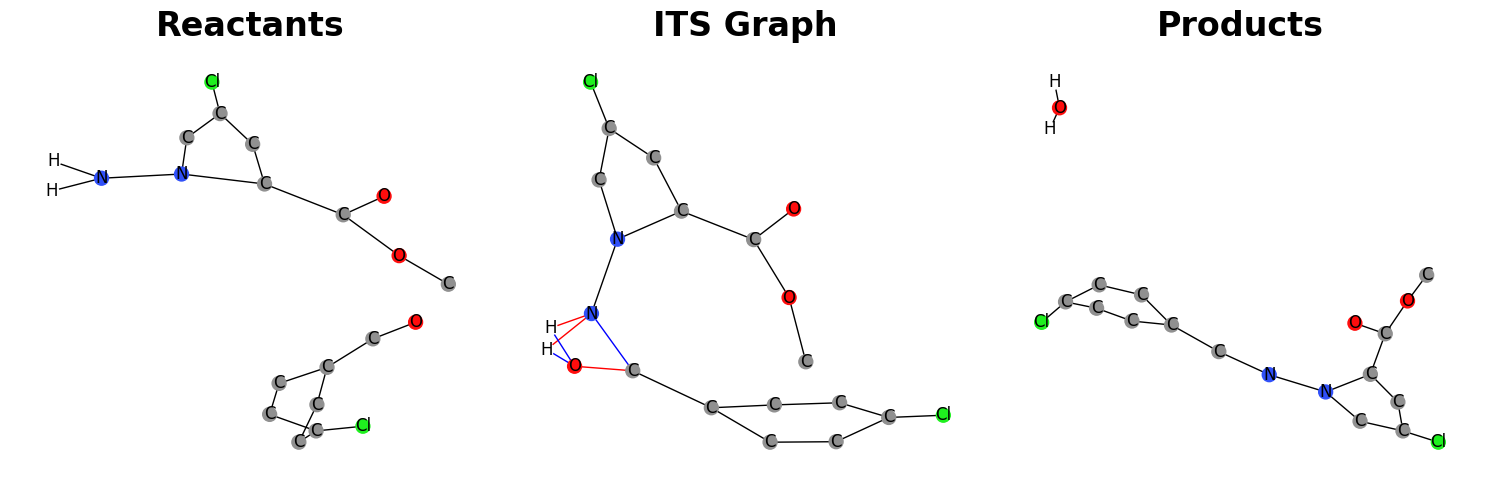

In [20]:
from SynTemp.SynVis.chemical_graph_visualizer import ChemicalGraphVisualizer
vis_graph = ChemicalGraphVisualizer(42)
vis_graph.vis_three_graph(batch_processed[2050]['ITSGraph'])

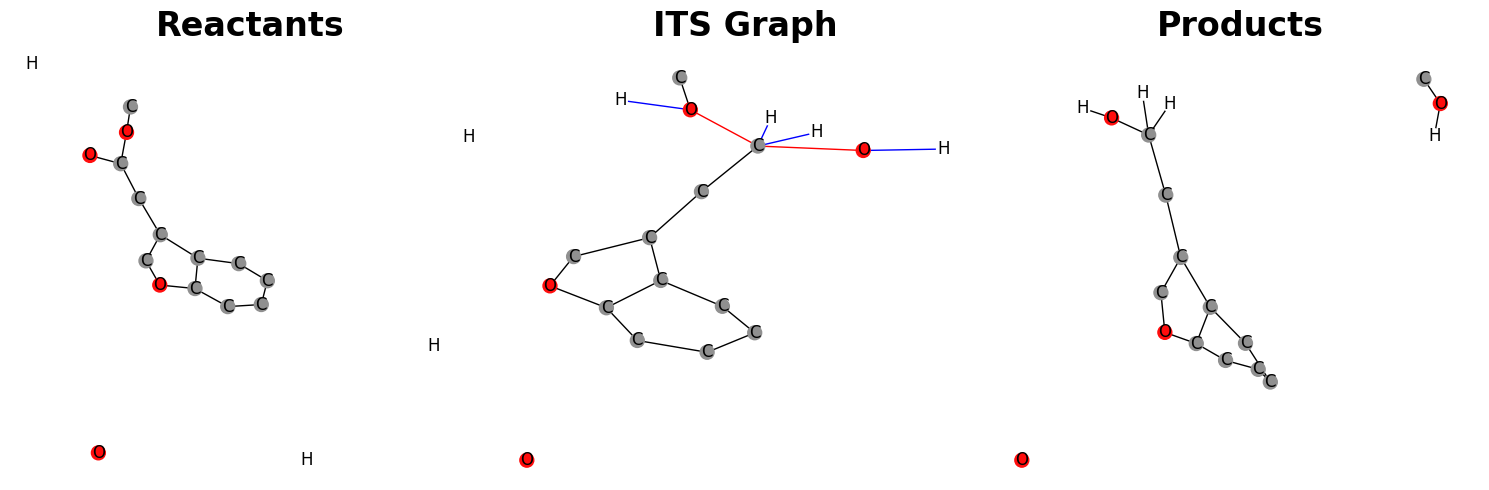

In [21]:
from SynTemp.SynVis.chemical_graph_visualizer import ChemicalGraphVisualizer

vis_graph = ChemicalGraphVisualizer(42)

vis_graph.vis_three_graph(batch_processed[0]['ITSGraph'])

# Disconnected

In [ ]:
# test = [{'R-id': 30683,
#  'reactions': 'CC(C)(C)OC(=O)N1CCC(=O)CC1.N#Cc1ccc(N)cc1.[H].[H]>>CC(C)(C)OC(=O)N1CCC(Nc2ccc(C#N)cc2)CC1.O',
#  'local_mapper': '[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[N:8]1[CH2:9][CH2:10][C:11](=[O:23])[CH2:21][CH2:22]1.[N:18]#[C:17][c:16]1[cH:15][cH:14][c:13]([NH2:12])[cH:20][cH:19]1.[H][H]>>[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[N:8]1[CH2:9][CH2:10][CH:11]([NH:12][c:13]2[cH:14][cH:15][c:16]([C:17]#[N:18])[cH:19][cH:20]2)[CH2:21][CH2:22]1.[OH2:23]',
#  'rxn_mapper': '[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[N:8]1[CH2:9][CH2:10][C:11](=[O:23])[CH2:21][CH2:22]1.[N:18]#[C:17][c:16]1[cH:15][cH:14][c:13]([NH2:12])[cH:20][cH:19]1.[H][H]>>[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[N:8]1[CH2:9][CH2:10][CH:11]([NH:12][c:13]2[cH:14][cH:15][c:16]([C:17]#[N:18])[cH:19][cH:20]2)[CH2:21][CH2:22]1.[OH2:23]',
#  'graphormer': '[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[N:8]1[CH2:9][CH2:10][C:11]([CH2:13][CH2:14]1)=[O:12].[H:24][H:25].[cH:19]1[cH:18][c:17]([cH:23][cH:22][c:20]1[NH2:21])[C:16]#[N:15]>>[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[N:8]1[CH2:9][CH2:10][CH:11]([CH2:13][CH2:14]1)[NH:21][c:20]1[cH:19][cH:18][c:17]([cH:23][cH:22]1)[C:16]#[N:15].[OH2:12]',
#  'class': 1}]

# its_good, _ = ITSExtraction.parallel_process_smiles(test[:], ['local_mapper', 'rxn_mapper', 'graphormer'], check_method='RC', confident_mapper= 'graphormer')

In [ ]:
from SynTemp.SynITS.its_extraction import ITSExtraction
its_good, _ = ITSExtraction.parallel_process_smiles(other_reactions, ['local_mapper', 'rxn_mapper', 'graphormer'], check_method='RC', confident_mapper= 'graphormer')

In [ ]:
from SynTemp.SynVis.chemical_graph_visualizer import ChemicalGraphVisualizer

vis_graph = ChemicalGraphVisualizer(42)
vis_graph.vis_three_graph(its_good[1]['ITSGraph'])

In [ ]:
from SynTemp.SynITS.its_hadjuster import ITSHAdjuster
batch_processed = ITSHAdjuster.process_graph_data_parallel(
                its_good[:], "ITSGraph", n_jobs=1, verbose=2
            )

In [ ]:
len(batch_processed)

In [ ]:
good = [value for value in batch_processed if value['ITSGraph']]

In [ ]:
rc_list = [value['GraphRules'][2] for value in good]

In [ ]:
from SynTemp.SynUtils.graph_utils import check_graph_connectivity

connect = [value for value in rc_list if check_graph_connectivity(value)=='Connected']
disconnect = [value for value in rc_list if check_graph_connectivity(value)=='Disconnected']

In [ ]:
len(connect)

In [ ]:
vis_graph.vis_three_graph(batch_processed[11]['GraphRules'])

In [ ]:
its_good[0]['ITSGraph']

In [ ]:
batch_processed

In [ ]:
vis_graph.vis_three_graph(batch_processed[0]['ITSGraph'])